## Numbers & Viz for Script 4

In [1]:
import torch
from transformers import pipeline
from torch.nn import functional as F
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config
from transformers import LlamaForCausalLM, PreTrainedTokenizerFast, LlamaConfig
from transformers import AutoModelForCausalLM, AutoTokenizer

device='cuda'

In [2]:
model_id = "meta-llama/Llama-3.2-1B"
# model_id = "openai-community/gpt2"
# model_id = "google/gemma-3-1b-pt"
# model_id = "gpt2"

In [3]:
# Random init
# model_config = GPT2Config() #Full sized model
# model = GPT2LMHeadModel(model_config).to(device) #Ok i should see what happens with full and pretrained model. 
# tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Not quite working for Llama, will take some noodling
# model_config  = LlamaConfig.from_dict(config_dict)
# model = LlamaForCausalLM(model_config).to(device) 
# tokenizer = AutoTokenizer.from_pretrained(model_id)

#Pretrained
model = AutoModelForCausalLM.from_pretrained(model_id).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [4]:
text = "The capital of France is Paris"
inputs = tokenizer(text, return_tensors="pt").to(device)
input_ids = inputs["input_ids"]

with torch.no_grad():
    outputs = model(input_ids, labels=input_ids)

my_probs=F.softmax(outputs.logits, dim=-1)
y_one_hot=F.one_hot(input_ids, num_classes=model.config.vocab_size)
correct_next_token_probs = (my_probs[:,:-1]*y_one_hot[:,1:]).sum(-1) #I'm sure there's waaay more efficient ways to do this
my_loss=-torch.log(correct_next_token_probs).mean()
print(my_loss.item(), outputs.loss.item())

3.3751838207244873 3.3751838207244873


Quick loss breakdown by token for paragraph 17b

In [5]:
-torch.log(correct_next_token_probs)

tensor([[3.6222, 8.6831, 0.5645, 4.4855, 1.9581, 0.9377]], device='cuda:0')

In [6]:
input_ids

tensor([[128000,    791,   6864,    315,   9822,    374,  12366]],
       device='cuda:0')

In [7]:
my_probs[0, 2, 315]

tensor(0.5687, device='cuda:0')

In [8]:
prompt="The capital of France is"
input_ids=tokenizer.encode(prompt, return_tensors="pt")

In [9]:
input_ids

tensor([[128000,    791,   6864,    315,   9822,    374]])

In [10]:
with torch.no_grad():
    out=model(input_ids.to(device))
probs = F.softmax(out.logits.detach().cpu(), dim=-1)

In [11]:
sI=np.argsort(probs[0,-1, :].detach().cpu().float().numpy())[::-1]

for i in sI[:10]:
    print(i, round(probs[0, -1, i].item(),5), tokenizer.decode([i]))

12366 0.39156  Paris
264 0.0842  a
279 0.0704  the
832 0.03096  one
1101 0.03061  also
2162 0.02528  home
3967 0.02462  known
539 0.01659  not
459 0.01241  an
7559 0.01172  located


Let’s start by visualizing the impact of just one of our one billion model parameters on our model’s output. The multilayer perceptron compute block in the model’s final layer has N total parameters, we’ll pick out one of these parameters, and see how it impacts our model’s final output. 

In [12]:
model.model.layers[-1].mlp

LlamaMLP(
  (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
  (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
  (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
  (act_fn): SiLU()
)

In [13]:
model.model.layers[-1].mlp.up_proj.weight.numel()

16777216

In [14]:
8192*2048

16777216

In [15]:
(2048*8192+2048*8192+8192*2048)/1e6

50.331648

Our parameter’s current value is XX.YY. Let’s increase this parameter’s value by N, rerun our input text through our model, and see how our predictions and loss changes. Our model’s predicted probability of a final token of Paris moves down a little to 0.XX. Testing a change in the other direction, decreasing our parameters value to  0.0XA, moves up our model’s confidence to 0.XX. So for this single parameter and for this example text, we now know that we can make our model more confident in the right answer by decreasing this parameter’s value. 

In [16]:
prompt2="The capital of France is Paris"
input_ids=tokenizer.encode(prompt2, return_tensors="pt")

out=model(input_ids.to(device), labels=input_ids.to(device))
out.loss.backward()

param_dict = {name: param for name, param in model.named_parameters()}
param_dict_2d={k:v for k,v in param_dict.items() if v.ndim>1}
grad_dict = {}

for p in param_dict:
    if param_dict[p].requires_grad:
        grad_dict[p] = param_dict[p].grad

grad_count=0
for g in grad_dict:
    grad_count+=grad_dict[g].numel()

grad_count/1e9

1.2358144

In [17]:
input_ids

tensor([[128000,    791,   6864,    315,   9822,    374,  12366]])

In [18]:
def get_random_param_name(param_dict_2d):
    random_layer_index=np.random.choice(len(param_dict_2d.keys()))
    random_layer_name=list(param_dict_2d.keys())[random_layer_index]
    return random_layer_name

def get_random_indices(t):
    random_i=np.random.choice(t.shape[0])
    random_j=np.random.choice(t.shape[1])
    return random_i, random_j

def top_n_abs_indices(arr, n=128):
    flat_indices = np.argsort(np.abs(arr).flatten())[-n:][::-1]
    return np.column_stack(np.unravel_index(flat_indices, arr.shape))

In [19]:
# [o[0] for o in model.named_parameters()]

- Ok so this is a litle messy, but I think the way to go, let's just measture the loss with respect to Paris

In [20]:
with torch.no_grad():
    out=model(input_ids.to(device))
probs = F.softmax(out.logits.detach().cpu(), dim=-1)
my_loss=-np.log(probs[0, 5, 12366].item())

In [21]:
my_loss.item()

0.9376176141361524

In [22]:
# p='model.layers.15.mlp.gate_proj.weight'
# p='model.layers.15.mlp.up_proj.weight'
p='model.layers.15.mlp.down_proj.weight'

In [23]:
top_indices=top_n_abs_indices(grad_dict[p].detach().cpu().float().numpy())

-0.007080078125


/tmp/ipykernel_51923/2446090319.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  my_loss=-np.log(probs[0, 5, 12366])


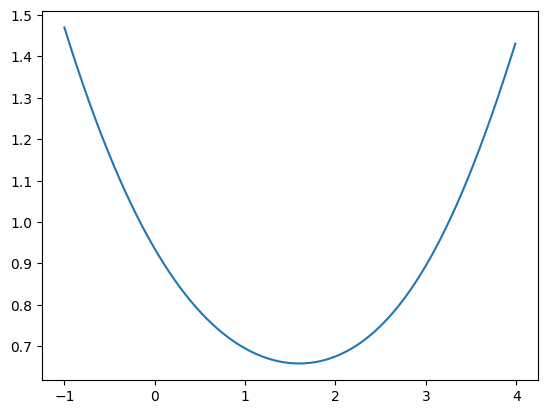

In [24]:
top_index=10 #55
n_stds=256
i_choice=top_indices[top_index][0]
j_choice=top_indices[top_index][1]

og_value=param_dict[p][i_choice, j_choice].item()
w_std=param_dict[p].detach().cpu().std().item()
print(og_value)

# xs=np.linspace(og_value-n_stds*w_std, og_value+n_stds*w_std, 31)
# xs=np.linspace(-1, 4, 255)
xs=np.arange(-1, 4, 0.01)
model.eval()
losses=[]; all_probs=[]
with torch.no_grad():
    for x in xs:
        param_dict[p][i_choice, j_choice]=x
        out=model(input_ids.to(device), labels=input_ids.to(device))
        # losses.append(out.loss.item())

        #Loss for just paris token
        probs = F.softmax(out.logits.detach().cpu(), dim=-1)
        my_loss=-np.log(probs[0, 5, 12366])
        losses.append(my_loss.item())
        all_probs.append(probs[0, 5, 12366].item())

    param_dict[p][i_choice, j_choice]=og_value

plt.plot(xs, losses)

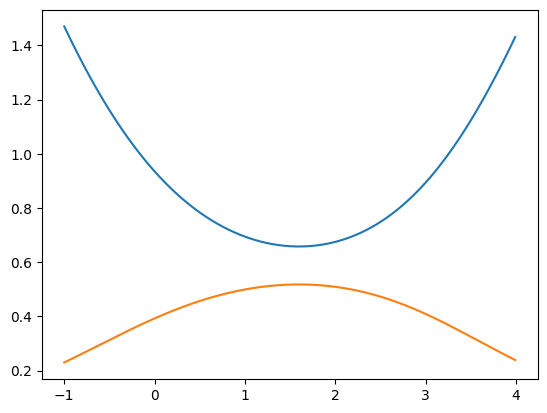

In [25]:
plt.plot(xs, losses)
plt.plot(xs, all_probs)
plt.savefig('p21_1.svg')

In [26]:
i_choice, j_choice, p, og_value

(np.int64(395),
 np.int64(1788),
 'model.layers.15.mlp.down_proj.weight',
 -0.007080078125)

In [27]:
with torch.no_grad():
    param_dict[p][i_choice, j_choice]=og_value
    out=model(input_ids.to(device), labels=input_ids.to(device))
    probs = F.softmax(out.logits.detach().cpu(), dim=-1)
    my_loss=-np.log(probs[0, 5, 12366])
    param_dict[p][i_choice, j_choice]=og_value
    print(param_dict[p][i_choice, j_choice], probs[0, 5, 12366], my_loss)

tensor(-0.0071, device='cuda:0', requires_grad=True) tensor(0.3916) tensor(0.9376)


/tmp/ipykernel_51923/1872347975.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  my_loss=-np.log(probs[0, 5, 12366])


In [28]:
with torch.no_grad():
    param_dict[p][i_choice, j_choice]=og_value+0.01
    out=model(input_ids.to(device), labels=input_ids.to(device))
    probs = F.softmax(out.logits.detach().cpu(), dim=-1)
    my_loss=-np.log(probs[0, 5, 12366])
    print(param_dict[p][i_choice, j_choice])
    param_dict[p][i_choice, j_choice]=og_value
    print(probs[0, 5, 12366], my_loss)

tensor(0.0029, device='cuda:0', requires_grad=True)
tensor(0.3930) tensor(0.9339)


/tmp/ipykernel_51923/2141805780.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  my_loss=-np.log(probs[0, 5, 12366])


In [29]:
with torch.no_grad():
    param_dict[p][i_choice, j_choice]=og_value-0.01
    out=model(input_ids.to(device), labels=input_ids.to(device))
    probs = F.softmax(out.logits.detach().cpu(), dim=-1)
    print(param_dict[p][i_choice, j_choice])
    my_loss=-np.log(probs[0, 5, 12366])
    param_dict[p][i_choice, j_choice]=og_value
    print(probs[0, 5, 12366], my_loss)

tensor(-0.0171, device='cuda:0', requires_grad=True)
tensor(0.3901) tensor(0.9414)


/tmp/ipykernel_51923/3024680267.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  my_loss=-np.log(probs[0, 5, 12366])


In [30]:
og_value

-0.007080078125

## Ok Now Whack a Mole

- Ok from here I think I need to go throug the whole exercise of picking and tweaking a second parameter, after "optimizing" the first parameter, I need to come back and show that the loss curve changed.

/tmp/ipykernel_51923/1052380754.py:21: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  my_loss=-np.log(probs[0, 5, 12366])


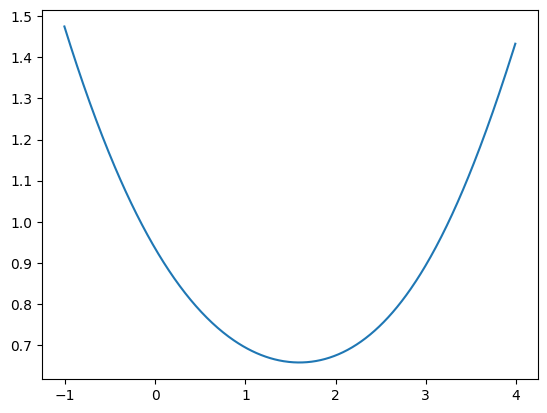

In [31]:
top_index=10 #55
n_stds=256
i_choice=top_indices[top_index][0]
j_choice=top_indices[top_index][1]

og_value=param_dict[p][i_choice, j_choice].item()
w_std=param_dict[p].detach().cpu().std().item()

# xs1=np.linspace(og_value-n_stds*w_std, og_value+n_stds*w_std,255)
xs1=np.arange(-1.007, 4, 0.01)
model.eval()
losses1=[]; all_probs_1=[]
with torch.no_grad():
    for x in xs1:
        param_dict[p][i_choice, j_choice]=x
        out=model(input_ids.to(device), labels=input_ids.to(device))
        # losses.append(out.loss.item())

        #Loss for just paris token
        probs = F.softmax(out.logits.detach().cpu(), dim=-1)
        my_loss=-np.log(probs[0, 5, 12366])
        losses1.append(my_loss.item())
        all_probs_1.append(probs[0, 5, 12366])

    param_dict[p][i_choice, j_choice]=og_value

plt.plot(xs1, losses1)

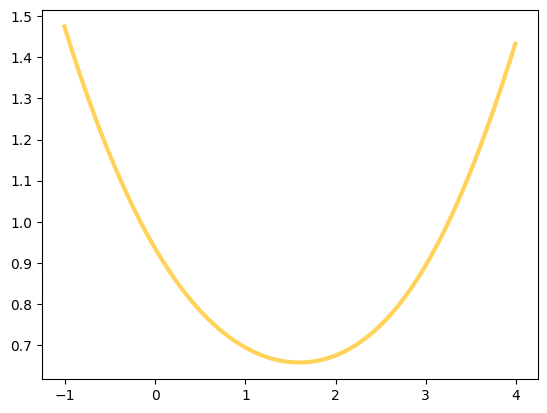

In [32]:
plt.plot(xs1, losses1, color='#ffd35a', linewidth=3)
plt.savefig('p24_1.svg')

In [34]:
np.array(all_probs_1)

array([0.22882706, 0.23044401, 0.2320626 , 0.23368737, 0.23531656,
       0.23694478, 0.23857982, 0.24021578, 0.241855  , 0.24349844,
       0.24514228, 0.24678978, 0.24844125, 0.25009394, 0.25175095,
       0.25340676, 0.255068  , 0.2567303 , 0.25839394, 0.260061  ,
       0.26172882, 0.26339695, 0.26506767, 0.26674077, 0.26841503,
       0.2700905 , 0.27176636, 0.27344248, 0.27512062, 0.27680013,
       0.27848032, 0.28015897, 0.28184107, 0.28352278, 0.2852033 ,
       0.2868845 , 0.28856587, 0.29024726, 0.2919291 , 0.29361013,
       0.2952898 , 0.29697034, 0.29865035, 0.3003298 , 0.30200648,
       0.30368367, 0.30535957, 0.30703646, 0.30870864, 0.31038314,
       0.31205454, 0.3137257 , 0.31539124, 0.31706107, 0.3187239 ,
       0.3203864 , 0.32204577, 0.3237045 , 0.3253611 , 0.32701612,
       0.32866627, 0.33031592, 0.3319589 , 0.33360296, 0.33524325,
       0.33688173, 0.33851585, 0.3401473 , 0.34177428, 0.34339893,
       0.3450176 , 0.34663743, 0.3482513 , 0.3498611 , 0.35146

In [37]:
i_choice, j_choice

(np.int64(1671), np.int64(1788))

In [32]:
xs1[np.argmin(losses1)] #Ok wow yeah that's a nice big move. 

np.float64(1.6030000000000022)

In [33]:
losses[np.argmin(losses1)]

0.6580110788345337

In [35]:
all_probs[np.argmin(losses1)]

0.5178803205490112

In [39]:
with torch.no_grad():
    param_dict[p][i_choice, j_choice]=xs1[np.argmin(losses1)]  #Make a semi-presistent change here, hopefully this doesn't fuck up my other curve to much. 

In [40]:
param_dict[p][i_choice, j_choice].item()

1.600000023841858

  0%|                                                  | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_42661/1059261437.py:21: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  my_loss=-np.log(probs[0, 5, 12366])
100%|████████████████████████████████████████| 250/250 [00:06<00:00, 40.19it/s]


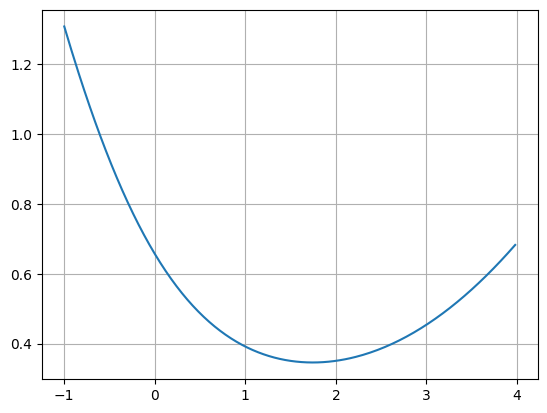

In [41]:
top_index=12 #75 #55 4 is not terrible
n_stds=256
i_choice=top_indices[top_index][0]
j_choice=top_indices[top_index][1]

og_value=param_dict[p][i_choice, j_choice].item()
w_std=param_dict[p].detach().cpu().std().item()

# xs=np.linspace(og_value-n_stds*w_std, og_value+n_stds*w_std, 255)
xs=np.arange(-1, 4, 0.02)
model.eval()
losses=[]
with torch.no_grad():
    for x in tqdm(xs):
        param_dict[p][i_choice, j_choice]=x
        out=model(input_ids.to(device), labels=input_ids.to(device))
        # losses.append(out.loss.item())

        #Loss for just paris token
        probs = F.softmax(out.logits.detach().cpu(), dim=-1)
        my_loss=-np.log(probs[0, 5, 12366])
        losses.append(my_loss.item())

    param_dict[p][i_choice, j_choice]=og_value

plt.plot(xs, losses); plt.grid(1)

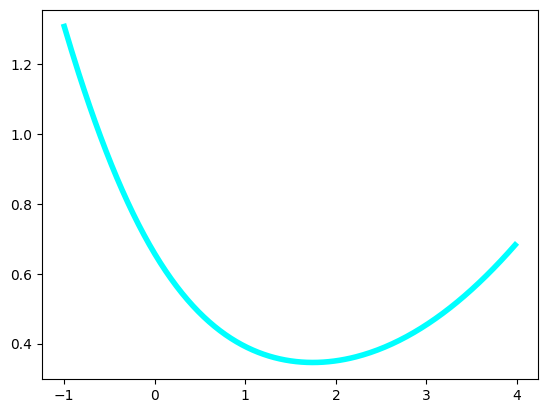

In [62]:
plt.plot(xs, losses, color='#00ffff', linewidth=4);
plt.savefig('p24_2.svg')

In [43]:
i_choice, j_choice

(np.int64(1671), np.int64(1788))

In [44]:
xs[np.argmin(losses)]

np.float64(1.7400000000000024)

In [45]:
with torch.no_grad():
    param_dict[p][i_choice, j_choice]=xs[np.argmin(losses)]

In [46]:
param_dict[p][i_choice, j_choice]

tensor(1.7400, device='cuda:0', grad_fn=<SelectBackward0>)

/tmp/ipykernel_42661/1753904747.py:22: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  my_loss=-np.log(probs[0, 5, 12366])


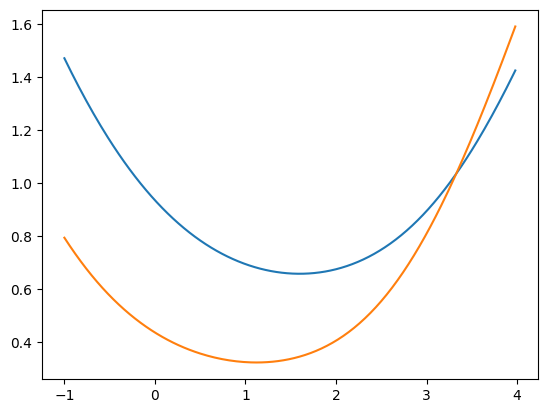

In [47]:
#Back to first variable
top_index=10 #55
n_stds=256
i_choice=top_indices[top_index][0]
j_choice=top_indices[top_index][1]

og_value=param_dict[p][i_choice, j_choice].item()
w_std=param_dict[p].detach().cpu().std().item()

# xs2=np.linspace(og_value-n_stds*w_std, og_value+n_stds*w_std, 255)
xs2=np.arange(-1, 4, 0.02)
model.eval()
losses2=[]
with torch.no_grad():
    for x in xs2:
        param_dict[p][i_choice, j_choice]=x
        out=model(input_ids.to(device), labels=input_ids.to(device))
        # losses.append(out.loss.item())

        #Loss for just paris token
        probs = F.softmax(out.logits.detach().cpu(), dim=-1)
        my_loss=-np.log(probs[0, 5, 12366])
        losses2.append(my_loss.item())

    param_dict[p][i_choice, j_choice]=og_value

plt.plot(xs1, losses1)
plt.plot(xs2, losses2)

- Ok so great that this is working! I wish these were a little more different - let me noodle a little.
- Ok indices 0 and 4 are not terrible together, i would like a wider shift if I can have one. 

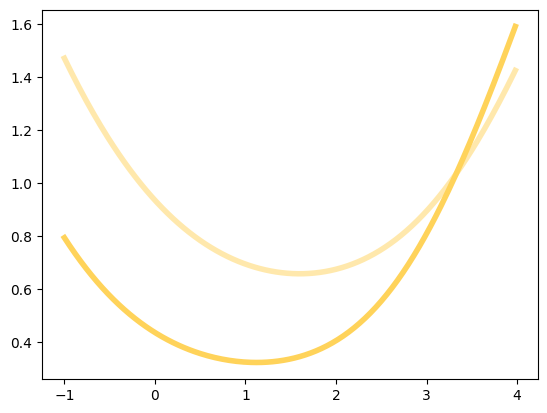

In [61]:
plt.plot(xs1, losses1, c='#ffd35a', linewidth=4, alpha=0.5)
plt.plot(xs2, losses2, c='#ffd35a', linewidth=4)
plt.savefig('p24_3.svg')

In [48]:
xs2[np.argmin(losses2)]

np.float64(1.1200000000000019)

---

In [ ]:
out.logits.shape

In [ ]:
with torch.no_grad():
    out=model(input_ids.to(device))
probs = F.softmax(out.logits.detach().cpu(), dim=-1)
my_loss=-np.log(probs[0, 5, 12366].item())

In [ ]:
my_loss

In [ ]:
i_choice, j_choice, p, og_value

In [ ]:
for top_index in range(100):
    i_choice=top_indices[top_index][0]
    j_choice=top_indices[top_index][1]
    
    og_value=param_dict[p][i_choice, j_choice].item()
    print(top_index, i_choice, j_choice, og_value)